# LuxonisDatasetFormat - testing embeddings methods

In [1]:
import os
import uuid
import numpy as np
import onnx
import onnxruntime
import torch
import torch.onnx
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from utils.data_utils import load_mnist_data

# only for local testing
import sys
# sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
sys.path.append('/home/paperspace/Luxonis/luxonis-ml')

from luxonis_ml.data import (
    LuxonisDataset,
    LuxonisLoader,
)
from luxonis_ml.utils import LuxonisFileSystem
from luxonis_ml.embeddings.utils.embedding import (
    extract_embeddings,
    extract_embeddings_onnx,
    extract_embeddings_onnx_LFS,
    load_embeddings,
    save_embeddings,
)
from luxonis_ml.embeddings.utils.ldf import generate_embeddings
from luxonis_ml.embeddings.utils.model import (
    export_model_onnx,
    extend_output_onnx,
    load_model,
    load_model_onnx,
    load_model_resnet50_minuslastlayer,
)
from luxonis_ml.embeddings.utils.weaviate import WeaviateAPI

/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pytorch examples

In [2]:
# Load the data
data_loader = load_mnist_data(save_path="./mnist", num_samples=640, batch_size=64)

In [3]:
# Load the model
model = load_model_resnet50_minuslastlayer()

In [4]:
# Extract embeddings from the dataset
embeddings, labels = extract_embeddings(model, data_loader)

In [5]:
save_embeddings(embeddings, labels)

## ONNX models and Weaviate

In [6]:
# Load the data
data_loader = load_mnist_data(save_path="./mnist", num_samples=640, batch_size=64)

In [7]:
# Load the model
model = load_model()

# Export the model to ONNX
export_model_onnx(model, model_path_out="resnet50.onnx")

# Load the ONNX model
onnx_model = load_model_onnx(model_path="resnet50.onnx")

# Extend the ONNX model with an intermediate output layer
onnx_model = extend_output_onnx(
    onnx_model, intermediate_tensor_name="/Flatten_output_0"
)

# Save the ONNX model
onnx.save(onnx_model, "resnet50-1.onnx")

In [8]:
# Create an ONNX Runtime session
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession("resnet50-1.onnx", providers=provider)

# Extract embeddings from the dataset
embeddings, labels = extract_embeddings_onnx(
    ort_session, data_loader, "/Flatten_output_0"
)

# Save the embeddings and labels to a file
save_embeddings(embeddings, labels)

2024-01-30 11:35:08.816636946 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [9]:
embeddings, labels = load_embeddings()
# must be list
embeddings = embeddings.tolist()
labels = labels.tolist()
labels = [str(label) for label in labels]

In [10]:
# Connect to Weaviate
weaviate_api = WeaviateAPI("http://localhost:8080", collection_name="Mnist28")
# weaviate_api = WeaviateAPI(url="http://localhost:8080", auth_key="YOUR_AUTH_KEY", collection_name="Mnist26")

In [11]:
# Create a collection
weaviate_api.create_collection(label=True)

# Insert the embeddings into the collection
uuids = [str(uuid.uuid5(uuid.NAMESPACE_DNS, str(e))) for e in embeddings]
weaviate_api.insert_embeddings(uuids, embeddings, labels, batch_size=50)

Collection Mnist28 does not exist. Creating...


In [12]:
# Search for the nearest neighbors
search_uuids, scores = weaviate_api.search_similar_embeddings(embeddings[0], top_k=5)
search_labels = weaviate_api.retrieve_labels_by_ids(search_uuids)

# Print the search results
for u,l in zip(search_uuids, search_labels):
    print(u, l)

8d2345c7-8133-5215-a2c7-c76a1d7072a1 8
743e7f84-047f-55fc-baa4-8b97b32f9c8e 9
3733842b-0acd-57b7-95b8-360448bae7e3 8
65d8278a-579b-5b65-a2d3-15b2acca61da 8
b2085014-6022-504c-a899-efa77252bfcc 8


## LuxonisDatasetFormat, ONNX and Weaviate

In [13]:
NUM_SAMPLES = 6400  # -1 # minus one is equivalent to all samples
BATCH_SIZE = 64

In [14]:
# Load the MNIST data
data_loader = load_mnist_data(
    save_path="./mnist", num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE
)
NUM_SAMPLES = len(data_loader.dataset)
print(f"Number of samples: {NUM_SAMPLES}")

Number of samples: 6400


In [15]:
# Create a tmp directory to store the images
mnist_image_dir = "./mnist_images"
if not os.path.exists(mnist_image_dir):
    os.makedirs(mnist_image_dir)

In [16]:
# Convert MNIST data to Luxonis ML format
def mnist_LDF_generator():
    batch_num = 0
    for batch in data_loader:
        images, labels = batch
        for i, (image, label) in enumerate(zip(images, labels)):
            img_ix = batch_num * BATCH_SIZE + i

            # Save image to disk
            # image_path = os.path.join(mnist_image_dir, f"mnist_{img_ix}.jpg")
            image_path = os.path.join(mnist_image_dir, f"{uuid.uuid4()}.jpg")
            torchvision.utils.save_image(image, image_path)

            # Create dictionary structure for Luxonis ML
            yield {
                "file": image_path,
                "class": str(label.item()),
                "type": "classification",
                "value": True,
            }
        batch_num += 1


In [17]:
# 2. Load the MNIST Data into LDF
dataset_name = "mnist_dataset29"

# Create a new dataset in LDF
dataset = LuxonisDataset(dataset_name)

In [18]:
# Add the MNIST data to the dataset
dataset.set_classes(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
dataset.add(mnist_LDF_generator)
dataset.make_splits()

100%|██████████| 6400/6400 [00:00<00:00, 19147.77it/s]


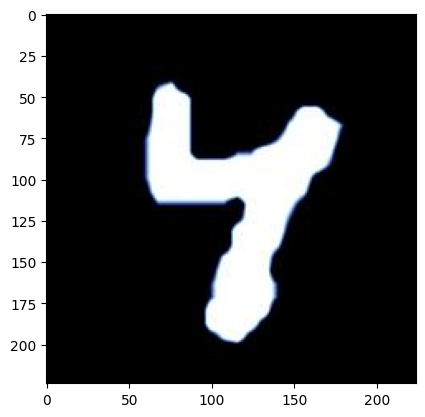

In [19]:
loader = LuxonisLoader(dataset)
for img, _ in loader:
    plt.imshow(img)
    plt.show()
    break

In [20]:
# Define the transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize the ONNX Runtime session for the model
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession("resnet50-1.onnx", providers=provider)

2024-01-30 11:35:35.761175098 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [21]:
# Setup Weaviate
weaviate_api = WeaviateAPI("http://localhost:8080", collection_name="Mnist29")
weaviate_api.create_collection(label=True, vector_size=2048, distance_metric="cosine")

Collection Mnist29 does not exist. Creating...


In [22]:
# Load the LuxonisDataset
emb_dict = generate_embeddings(
    dataset, ort_session, weaviate_api, output_layer_name="/Flatten_output_0", transform=transform
)

Upserted 6400 of embeddings to VectorDB.
Embeddings generation and insertion completed!


In [23]:
first_emb = None

# get a specific sample from dataset
first_sample = list(emb_dict.keys())[0]
first_emb = emb_dict[first_sample]
sample_id = first_sample

# sample_id = '64e758bdca1096d3483d18f4'
# sample = dataset.fo_dataset[sample_id]
df = dataset._load_df_offline()
sample = df[df["file"] == sample_id+".jpg"]
sample

,file,class,type,value,instance_id,value_type,created_at
0,12ff2837-0cfb-4221-8001-f7b9fba49a6f.jpg,0,classification,True,3015d027-11db-5a51-8d0c-aa0b5b16a489,bool,2024-01-30 11:35:35.148574


In [24]:
# Search for the nearest neighbors
search_uuids, scores = weaviate_api.search_similar_embeddings(first_emb, top_k=5)
search_labels = weaviate_api.retrieve_labels_by_ids(search_uuids)

# Print the search results
for u,l,s in zip(search_uuids, search_labels, scores):
    print(u, l, s)

12ff2837-0cfb-4221-8001-f7b9fba49a6f 0 -1.0728836059570312e-06
db974851-9533-4f3e-b273-124414a032ce 0 0.0414118766784668
f2f49a9d-486d-4124-aae7-cdbf6236e98f 0 0.04867053031921387
6ee7841a-2ead-4c48-bcf3-d96cec6d764e 0 0.052395761013031006
ed24caab-45e9-42a6-b1ae-70292f142b51 0 0.05418276786804199


## ONNX, LuxonisFileSystem and Weaviate
Using the LuxonisFileSystem we can extract embeddings of pictures stored locally, on GCS or S3.

In [25]:
# file_info = {
#     "base_path": "gcs-bucket-name",
#     "prefix": "path/to/dataset",
#     "model_path": "path/to/model.onnx",
# }

In [26]:
# lfs = LuxonisFileSystem("gs://" + file_info["base_path"]) 

# local_model = "./emb_model.onnx"
# lfs.get_file(file_info["model_path"], local_model)

In [27]:
current_dir = os.getcwd()
file_info = {
    "base_path": current_dir,
    "prefix": "mnist_images",
    "model_path": "resnet50-1.onnx",
}
local_model = file_info["model_path"]

In [28]:
# Define the transform
transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize the ONNX Runtime session for the model
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession(local_model, providers=provider)

2024-01-30 11:37:12.738478469 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [29]:
lfs_local = LuxonisFileSystem(file_info["base_path"])

In [30]:
files = []
for i,f in enumerate(lfs_local.walk_dir(file_info["prefix"])):
    if f.endswith(".png") or f.endswith(".jpg"):    
        files.append(f)
    if i > 100:
        break


In [31]:
# testing image conversion errors
files.append(file_info["prefix"] + "/non_existing_file.jpg")

In [32]:
embeddings, succ_ix = extract_embeddings_onnx_LFS(
    files,
    ort_session,
    transform,
    lfs_local,
    output_layer_name="/Flatten_output_0",
    batch_size=64,
)

Error occured while processing image:  mnist_images/non_existing_file.jpg


In [33]:
len(succ_ix), len(embeddings), len(files)
# assert len(embeddings) == len(succ_ix)
# assert len(embeddings) == len(files)
# assert len(succ_ix) == len(files)

(102, 102, 103)

In [34]:
# print the failed files
for i in range(len(files)):
    if i not in succ_ix:
        print(files[i])

mnist_images/non_existing_file.jpg


In [35]:
# Setup Weaviate
weaviate_api = WeaviateAPI("http://localhost:8080", collection_name="Mnist_LFS2")
weaviate_api.create_collection(label=True)

Collection Mnist_LFS2 does not exist. Creating...


In [36]:
#uuids = [str(uuid.uuid4()) for _ in range(len(embeddings))]
# uuids = names of successfully processed files
uuids = [files[i].split("/")[-1].split(".")[0] for i in succ_ix]

In [37]:
weaviate_api.insert_embeddings(
    uuids, embeddings, batch_size=50
)

In [38]:
# Search for the nearest neighbors
search_uuids, scores = weaviate_api.search_similar_embeddings(embeddings[0], top_k=5)

# Print the search results
for u,s in zip(search_uuids, scores):
    print(u, s)

000027d0-a1a9-46f6-ab41-f402e51c92c9 8.344650268554688e-07
00898cc6-d0b9-4010-b5ee-d01507bb58dc 0.05270969867706299
00ce96a6-aa91-4569-9c55-9c43342c6ed4 0.07034039497375488
008ed88c-0bbb-45d3-9f49-3c4920b50ab7 0.07670629024505615
0024392f-0b2a-466e-bbee-785790548894 0.0791628360748291


## Embeddings Processing

In [39]:
# look at the Embeddings_Processing_Example.ipynb for the rest of the code

## Remove everything

In [40]:
# ! rm -rf ./mnist_images
# ! rm -rf ./mnist
# ! rm ./resnet50.onnx
# ! rm ./resnet50-1.onnx
# ! rm ./embeddings.pth
# ! rm ./labels.pth

In [41]:
# # Delete the collection
# weaviate_api = WeaviateAPI("http://localhost:8080", collection_name="Mnist")
# weaviate_api.delete_collection()

In [42]:
# # Delete the Luxonis ML dataset
# dataset.delete_dataset()